In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic,KNNWithMeans,accuracy
from surprise.model_selection import train_test_split

### clayrs

In [ ]:
import clayrs.content_analyzer as ca
import clayrs.recsys as rs
import clayrs.evaluation as eva

In [14]:
source = ca.CSVFile('./data/anime_with_synopsis.csv')

In [15]:
animes_ca_config = ca.ItemAnalyzerConfig(source=source, id='MAL_ID', output_directory='animes_codified/')

In [16]:
animes_ca_config.add_single_config('sypnopsis', ca.FieldConfig(ca.SkLearnTfIdf(), preprocessing=ca.NLTK(stopwords_removal=True, lemmatization=True), id='tfidf'))

In [ ]:
ca.ContentAnalyzer(animes_ca_config).fit()

In [ ]:
ratings = ca.Ratings(ca.CSVFile('./data/rating_complete.csv'))

In [ ]:
#archive has 5 files:
# - anime.csv : list animes with characteristics. Interesting columns : genres, studio, type, rating (age), episodes, source
# - anime_with_synopsis.csv : same as above
# - animelist.csv : users with user_id, anime_id, rating, watching_status, watched_episodes
# - rating_complete.csv : part of animelist with only completed and rated animes 
# - watching_status.csv : all possible status for watching_status in animelist

### Surprise

In [10]:
df_ = pd.read_csv('./data/anime.csv')

In [16]:
df_['Genres_list'] = df_.Genres.apply(lambda x: x.split(', '))

In [33]:
df_pers = pd.merge(pd.DataFrame([(40028,1),(9253,10),(38524,1),(820,10)], columns=['MAL_ID', 'rating']), df_, how='inner', on='MAL_ID')

In [ ]:
# df = pd.read_csv('./data/animelist.csv', usecols=range(3), header=0, names=('user', 'item', 'rating'))
# df = df.query('rating!=0') #filter rows with 0 as rating: user has added the anime to his list but not rated it yet

In [25]:
df = pd.read_csv('./data/rating_complete.csv', usecols=range(3), header=0, names=('user', 'item', 'rating'), nrows=500000) #limit row to 500k for tests or things take a while

In [66]:
df_pers['user']=df.user.max()+1
df_pers = df_pers.rename(columns={'MAL_ID':'item'})

df = pd.concat([df,df_pers.loc[:,['user','item','rating']]], ignore_index=True)

In [14]:
df_top10 = df_.query('Score!="Unknown"').sort_values(by='Score', ascending=False).head(10)

In [18]:
genres_tout = dict(Counter([genre for genre_list in df_.Genres_list for genre in genre_list]))
genres_pers = Counter([genre for genre_list in df_pers.Genres_list for genre in genre_list])

In [19]:
# df_top10[df_top10.Genres_list.map(set(['Military']).issubset)] #select animes with military as a genre

In [26]:
{k:(v,v/len(df_)) for k, v in genres_tout.items()} #rate of genres for all animes

{'Action': (3888, 0.22138708575333105),
 'Adventure': (2957, 0.16837490035303496),
 'Comedy': (6029, 0.3432980298371484),
 'Drama': (2619, 0.14912880081995217),
 'Sci-Fi': (2583, 0.1470789203963102),
 'Space': (495, 0.02818585582507687),
 'Mystery': (727, 0.041396196332991686),
 'Shounen': (2003, 0.11405306912652317),
 'Police': (247, 0.014064457351098963),
 'Supernatural': (1479, 0.08421592073795696),
 'Magic': (1081, 0.06155335383213757),
 'Fantasy': (3285, 0.18705158865732832),
 'Sports': (713, 0.040599020612686484),
 'Josei': (97, 0.005523288919257488),
 'Romance': (1899, 0.10813119234711309),
 'Slice of Life': (1914, 0.10898530919029724),
 'Cars': (133, 0.007573169342899442),
 'Seinen': (830, 0.04726113198952284),
 'Horror': (462, 0.026306798770071745),
 'Psychological': (345, 0.019644687393235393),
 'Thriller': (131, 0.007459287097141555),
 'Super Power': (632, 0.035986789659492084),
 'Martial Arts': (425, 0.02419997722355085),
 'School': (1642, 0.0934973237672247),
 'Ecchi': (76

In [83]:
df_mil = df_[df_.Genres_list.map(set(['Military']).issubset)]
df_mil = pd.merge(df_mil, df, how='inner', left_on='MAL_ID', right_on='item')

In [67]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df, reader)
# data = Dataset.load_from_df(df_mil.loc[:,['user','item','rating']], reader)

In [68]:
# split dataset into 80% train and 20% test
trainset, testset=train_test_split(data, test_size=0.2)

In [69]:
#user-based Cosine
sim_options = {
    "user_based": True,  # compute  similarities between users
    "name":"cosine"
}

# # With K=20 neighbors
# algo = KNNBasic(sim_options=sim_options,k=20, min_k=5) #default value of k is 40
 
# #cv=cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, return_train_measures=True, verbose=True)
# algo.fit(trainset) # compute similarities
# predictions = algo.test(testset)
# accuracy.rmse(predictions)
# accuracy.mae(predictions)

# Let us make K change K=40
algo = KNNBasic(sim_options=sim_options,k=40, min_k=5) #default value of k is 40
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.5266
MAE:  1.1510


1.1510471151835475

In [79]:
len(df.user.unique())

2826

In [113]:
last_user = algo.trainset.to_inner_uid(df.user.max()) #retrieve last user (should be new one we inserted)
df_rec = pd.DataFrame([algo.trainset.to_raw_uid(x) for x in algo.get_neighbors(last_user,10)], columns=['user']) #create df with list of nearest users
df_rec = pd.merge(df_rec, df, how='inner', on='user') #merge with df that contain ratings
df_rec = df_rec.groupby('item').rating.median().sort_values(ascending=False).head(10) #compute median of ratings by users and select top 10 rated animes 

In [114]:
pd.merge(df_rec, df_, how='inner', left_on='item', right_on='MAL_ID')

,rating,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Genres_list
0,10.0,474,Macross Plus,7.72,"Drama, Mecha, Military, Romance, Sci-Fi, Space",Unknown,マクロスプラス,OVA,4,"Aug 25, 1994 to Jun 25, 1995",...,3575.0,5376.0,4487.0,1836.0,736.0,232.0,88.0,42.0,35.0,"[Drama, Mecha, Military, Romance, Sci-Fi, Space]"
1,10.0,18247,IS: Infinite Stratos 2,6.55,"Action, Sci-Fi, Harem, Comedy, Ecchi, Mecha",Infinite Stratos 2,IS〈インフィニット・ストラトス〉2,TV,12,"Oct 4, 2013 to Dec 20, 2013",...,13584.0,28200.0,47025.0,35178.0,20562.0,11477.0,6070.0,3657.0,2235.0,"[Action, Sci-Fi, Harem, Comedy, Ecchi, Mecha]"
2,10.0,18097,Inazuma Eleven Go: Galaxy,6.65,"Shounen, Sports, Super Power",Unknown,イナズマイレブンＧＯ ギャラクシー,TV,43,"May 8, 2013 to Mar 19, 2014",...,1351.0,2868.0,4783.0,3746.0,2040.0,1095.0,562.0,298.0,191.0,"[Shounen, Sports, Super Power]"
3,10.0,18095,Nourin,6.82,"Comedy, Parody, Romance, Ecchi, School",No-Rin,のうりん,TV,12,"Jan 11, 2014 to Mar 29, 2014",...,4904.0,12263.0,20229.0,12721.0,6543.0,2828.0,1129.0,619.0,376.0,"[Comedy, Parody, Romance, Ecchi, School]"
4,10.0,24699,Ai Tenchi Muyou!,6.19,"Comedy, Sci-Fi, Shounen",Unknown,愛・天地無用!,TV,50,"Oct 6, 2014 to Dec 26, 2014",...,411.0,1023.0,2087.0,2152.0,1468.0,821.0,386.0,232.0,179.0,"[Comedy, Sci-Fi, Shounen]"
5,10.0,2598,Juusenki L-Gaim,6.7,"Action, Sci-Fi, Adventure, Space, Drama, Mecha...",Unknown,重戦機エルガイム,TV,54,"Feb 4, 1984 to Feb 23, 1985",...,71.0,152.0,226.0,176.0,108.0,48.0,21.0,8.0,5.0,"[Action, Sci-Fi, Adventure, Space, Drama, Mech..."
6,10.0,2582,Soukou Kihei Votoms,7.73,"Action, Space, Mecha, Military, Drama, Sci-Fi",Armored Trooper Votoms,装甲騎兵ボトムズ,TV,52,"Apr 1, 1983 to Mar 23, 1984",...,852.0,1359.0,1021.0,457.0,227.0,87.0,31.0,18.0,17.0,"[Action, Space, Mecha, Military, Drama, Sci-Fi]"
7,10.0,2484,Gear Fighter Dendoh,7.19,"Action, Adventure, Mecha, School, Sci-Fi, Space",Unknown,GEAR戦士 電童,TV,38,"Oct 4, 2000 to Jun 27, 2001",...,83.0,239.0,330.0,129.0,62.0,21.0,13.0,2.0,4.0,"[Action, Adventure, Mecha, School, Sci-Fi, Space]"
8,10.0,5153,Kikou Kai Galient,6.44,"Action, Sci-Fi, Fantasy, Mecha",Unknown,機甲界ガリアン,TV,25,"Oct 5, 1984 to Mar 29, 1985",...,36.0,80.0,159.0,142.0,78.0,49.0,17.0,6.0,5.0,"[Action, Sci-Fi, Fantasy, Mecha]"
9,10.0,17641,Date A Live: Date to Date,7.37,"Sci-Fi, Harem, Comedy, Romance, School",Unknown,デート・ア・ライブ DATE TO DATE,OVA,1,"Dec 6, 2013",...,10237.0,20471.0,24727.0,11358.0,5082.0,1817.0,811.0,422.0,297.0,"[Sci-Fi, Harem, Comedy, Romance, School]"


In [115]:
#one line version of above
pd.merge(pd.merge(pd.DataFrame([algo.trainset.to_raw_uid(x) for x in algo.get_neighbors(2765,10)], columns=['user']), df, how='inner', on='user').groupby('item').rating.median().sort_values(ascending=False).head(10), df_, how='inner', left_on='item', right_on='MAL_ID')

,rating,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Genres_list
0,10.0,474,Macross Plus,7.72,"Drama, Mecha, Military, Romance, Sci-Fi, Space",Unknown,マクロスプラス,OVA,4,"Aug 25, 1994 to Jun 25, 1995",...,3575.0,5376.0,4487.0,1836.0,736.0,232.0,88.0,42.0,35.0,"[Drama, Mecha, Military, Romance, Sci-Fi, Space]"
1,10.0,18247,IS: Infinite Stratos 2,6.55,"Action, Sci-Fi, Harem, Comedy, Ecchi, Mecha",Infinite Stratos 2,IS〈インフィニット・ストラトス〉2,TV,12,"Oct 4, 2013 to Dec 20, 2013",...,13584.0,28200.0,47025.0,35178.0,20562.0,11477.0,6070.0,3657.0,2235.0,"[Action, Sci-Fi, Harem, Comedy, Ecchi, Mecha]"
2,10.0,18097,Inazuma Eleven Go: Galaxy,6.65,"Shounen, Sports, Super Power",Unknown,イナズマイレブンＧＯ ギャラクシー,TV,43,"May 8, 2013 to Mar 19, 2014",...,1351.0,2868.0,4783.0,3746.0,2040.0,1095.0,562.0,298.0,191.0,"[Shounen, Sports, Super Power]"
3,10.0,18095,Nourin,6.82,"Comedy, Parody, Romance, Ecchi, School",No-Rin,のうりん,TV,12,"Jan 11, 2014 to Mar 29, 2014",...,4904.0,12263.0,20229.0,12721.0,6543.0,2828.0,1129.0,619.0,376.0,"[Comedy, Parody, Romance, Ecchi, School]"
4,10.0,24699,Ai Tenchi Muyou!,6.19,"Comedy, Sci-Fi, Shounen",Unknown,愛・天地無用!,TV,50,"Oct 6, 2014 to Dec 26, 2014",...,411.0,1023.0,2087.0,2152.0,1468.0,821.0,386.0,232.0,179.0,"[Comedy, Sci-Fi, Shounen]"
5,10.0,2598,Juusenki L-Gaim,6.7,"Action, Sci-Fi, Adventure, Space, Drama, Mecha...",Unknown,重戦機エルガイム,TV,54,"Feb 4, 1984 to Feb 23, 1985",...,71.0,152.0,226.0,176.0,108.0,48.0,21.0,8.0,5.0,"[Action, Sci-Fi, Adventure, Space, Drama, Mech..."
6,10.0,2582,Soukou Kihei Votoms,7.73,"Action, Space, Mecha, Military, Drama, Sci-Fi",Armored Trooper Votoms,装甲騎兵ボトムズ,TV,52,"Apr 1, 1983 to Mar 23, 1984",...,852.0,1359.0,1021.0,457.0,227.0,87.0,31.0,18.0,17.0,"[Action, Space, Mecha, Military, Drama, Sci-Fi]"
7,10.0,2484,Gear Fighter Dendoh,7.19,"Action, Adventure, Mecha, School, Sci-Fi, Space",Unknown,GEAR戦士 電童,TV,38,"Oct 4, 2000 to Jun 27, 2001",...,83.0,239.0,330.0,129.0,62.0,21.0,13.0,2.0,4.0,"[Action, Adventure, Mecha, School, Sci-Fi, Space]"
8,10.0,5153,Kikou Kai Galient,6.44,"Action, Sci-Fi, Fantasy, Mecha",Unknown,機甲界ガリアン,TV,25,"Oct 5, 1984 to Mar 29, 1985",...,36.0,80.0,159.0,142.0,78.0,49.0,17.0,6.0,5.0,"[Action, Sci-Fi, Fantasy, Mecha]"
9,10.0,17641,Date A Live: Date to Date,7.37,"Sci-Fi, Harem, Comedy, Romance, School",Unknown,デート・ア・ライブ DATE TO DATE,OVA,1,"Dec 6, 2013",...,10237.0,20471.0,24727.0,11358.0,5082.0,1817.0,811.0,422.0,297.0,"[Sci-Fi, Harem, Comedy, Romance, School]"


In [77]:
#user-based Pearson
sim_options = {
    "user_based": True,  # compute  similarities between users
    "name":"pearson"
}
algo = KNNWithMeans(sim_options=sim_options,k=40, min_k=5) #default value of k is 40

#cv=cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, return_train_measures=True, verbose=True)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6189
MAE:  1.1855


1.1855499999999999

In [86]:
#item-based (Cosine)
sim_options = {
    "user_based": False,  # compute similarities between items
    "name":"cosine"
}
algo = KNNBasic(sim_options=sim_options,k=40, min_k=5) #default value of k is 40

#cv=cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, return_train_measures=True, verbose=True)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4094
MAE:  1.0842


1.0841719529057865

In [ ]:
df_mil.drop_duplicates(subset='item')

In [139]:
algo.trainset.to_inner_iid(47)

37

In [140]:
pd.merge(pd.DataFrame([algo.trainset.to_raw_iid(x) for x in algo.get_neighbors(37,10)], columns=['MAL_ID']), df_, how='inner', on='MAL_ID')

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Genres_list
0,39634,Boy General,Unknown,"Action, Drama, Historical, Military",Boy General,소년장수,TV,50,1982 to 1997,Unknown,...,Unknown,Unknown,1.0,Unknown,4.0,1.0,1.0,Unknown,5.0,"[Action, Drama, Historical, Military]"
1,40554,"""Uchuu Senkan Yamato"" to Iu Jidai: Seireki 220...",Unknown,"Action, Military, Sci-Fi, Space, Drama",Unknown,『宇宙戦艦ヤマト』という時代 西暦2202年の選択,Movie,1,Unknown,Unknown,...,2.0,2.0,5.0,2.0,2.0,Unknown,Unknown,Unknown,Unknown,"[Action, Military, Sci-Fi, Space, Drama]"
2,41714,Soukyuu no Fafner: Dead Aggressor - The Beyond...,Unknown,"Action, Military, Sci-Fi, Drama, Mecha",Unknown,蒼穹のファフナー Dead Aggressor THE BEYOND,Movie,3,"Nov 13, 2020",Unknown,...,3.0,5.0,8.0,4.0,3.0,2.0,1.0,Unknown,3.0,"[Action, Military, Sci-Fi, Drama, Mecha]"
3,42465,Guan Hai Ce Zhi Tie Qi Xiong Guan,Unknown,"Action, Military, Historical, Martial Arts, Fa...",Unknown,观海策之铁骑雄关,ONA,16,"Apr 26, 2020 to Jul 26, 2020",Unknown,...,1.0,Unknown,4.0,3.0,1.0,1.0,2.0,1.0,4.0,"[Action, Military, Historical, Martial Arts, F..."
4,45444,Moshi Juexing Zhi Ruqin,Unknown,"Action, Mecha, Military, Sci-Fi",Unknown,末世觉醒之入侵,ONA,13,"May 24, 2018 to Aug 9, 2018",Unknown,...,Unknown,Unknown,3.0,3.0,Unknown,Unknown,Unknown,Unknown,Unknown,"[Action, Mecha, Military, Sci-Fi]"
5,45445,Moshi Juexing Zhi Ruqin 2nd Season,Unknown,"Action, Mecha, Military, Sci-Fi",Unknown,末世觉醒之入侵,ONA,13,"Jul 11, 2019 to Oct 3, 2019",Unknown,...,Unknown,2.0,1.0,2.0,1.0,Unknown,Unknown,Unknown,Unknown,"[Action, Mecha, Military, Sci-Fi]"
6,42323,Nanjung Ilgi,Unknown,"Historical, Military",Admiral's Diary,난중일기,Movie,1,"Jul 19, 1997",Unknown,...,Unknown,1.0,Unknown,2.0,Unknown,Unknown,Unknown,Unknown,1.0,"[Historical, Military]"
7,36429,Zhen Gyi Hong Shi,Unknown,"Action, Military, Sci-Fi, Adventure, Mecha",World Peacekeepers,正义红师,TV,52,"Oct 4, 2014 to Nov, 2014",Fall 2014,...,1.0,3.0,5.0,9.0,5.0,3.0,2.0,4.0,3.0,"[Action, Military, Sci-Fi, Adventure, Mecha]"
8,17117,Aoi Kioku: Manmou Kaitaku to Shounen-tachi,Unknown,"Drama, Historical, Military",Unknown,蒼い記憶 満蒙開拓と少年たち,Movie,1,"Dec 18, 1993",Unknown,...,2.0,7.0,11.0,24.0,12.0,5.0,1.0,Unknown,4.0,"[Drama, Historical, Military]"
9,41205,Kouya no Kotobuki Hikoutai Kanzenban,Unknown,"Action, Military, Adventure",The Magnificent Kotobuki,荒野のコトブキ飛行隊 完全版,Movie,1,"Sep 11, 2020",Unknown,...,1.0,3.0,7.0,6.0,3.0,2.0,Unknown,1.0,3.0,"[Action, Military, Adventure]"


In [ ]:
# user-based with Pearson and cross-validation
sim_options = {
    "name": "pearson",
    "user_based": True,  # compute  similarities between items
}
algo = KNNBasic(sim_options=sim_options, k=40,min_k=20)
cv=cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

In [ ]:
# Visualize
rmse = cv['test_rmse']
mae = cv['test_mae']
x = np.arange(len(rmse))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 2, 1.0))
plt.ylim(0.5, 2)
ax.plot(x, rmse, marker='o', label="rmse")
ax.plot(x, mae, marker='o', label="mae")

# Chart setup
plt.title("Test set errors", fontsize = 12)
plt.xlabel("Fold", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.legend()
plt.show()

## Stats

In [161]:
n = len(df.rating.unique())
cols = [tuple([deb+(fin-deb)/n*x for fin,deb in zip((0.19, 0.9, 0.29), (0.92,0.12,0.18))]) for x in range(n)] #gradient

<Axes: >

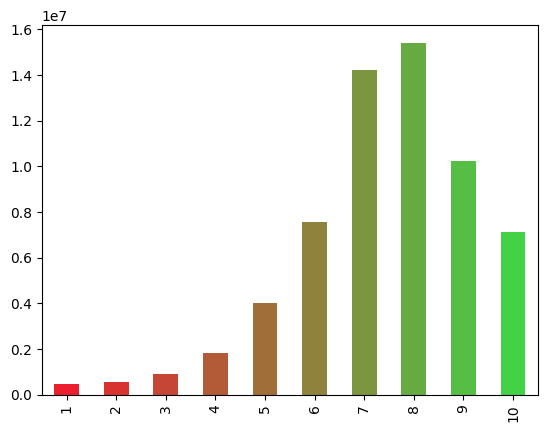

In [165]:
#repartition of ratings
df.rating.value_counts().sort_index().plot.bar(color=cols)

<Axes: >

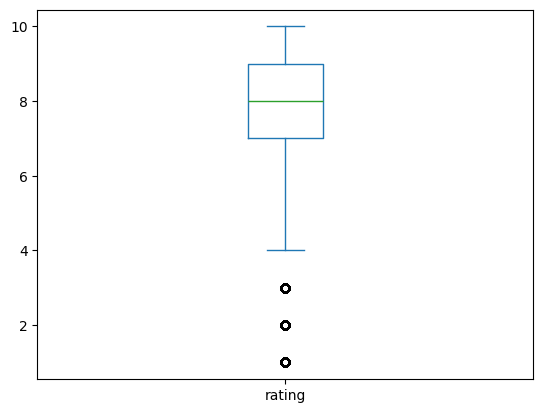

In [166]:
#repartition of ratings
df.rating.plot.box()

In [182]:
print('Number of animes:', len(df.anime_id.unique()))
print('Number of users:', len(df.user_id.unique()))
print('Number of rows:', len(df))

print('Median rating:', df.rating.median())
print('Average rating:', round(df.rating.mean(),3))

Number of animes: 17172
Number of users: 313670
Number of rows: 62397712
Median rating: 8.0
Average rating: 7.432


In [16]:
print('Average number of ratings per user:', round(df.groupby('user').rating.count().mean(),2))
print('Median number of ratings per user:',df.groupby('user').rating.count().median())

Average number of ratings per user: 185.88
Median number of ratings per user: 113.0
